# Face Recognition Challenge - Parth S. Patel

Code: https://github.com/parthspatel/Face-Recognition-Challenge

## Problem:
We will try to build a classification model that will run through multiple 2d pics of famous celebreties and predict name based on image.

## Solution:

I have attempted to improve the algorithm throught the following methods:
* data augmentation, to increase data quantity
* convolutional neural network, to learn features and classify the images better
* directed grid search, to optimize the convolutional neural network   

Currently I am in the process of training the model on augmented data, due to the increased size of the data it is taking much longer to run than expected.  The a overview of the training can be viewed at the end of the notebook.

Some of the complications I ran into, was that when using sklearn the models were performing worse or marginally better than the provided method using PCA, Grid Search, and a SVM.  Thus I chose to reposition to a CNN.  Initially, I trained the data on the FaceNet, ResNet, and AlexNet models. However, I quickly learned that neither of the three would work well for this task.  It is dificult to develop a highly accurate model with only 3k datasamples for 62 classes.  So, I simplified the model and then used a directed grid search to optimize the model.  However, the grid search was unable to find a suitable model that was not severly overfitting or underfitting.  Thus, I deemed that it was necesary to increase the data quantity.  Using data augmentation, I was able to increase the data size by 5.  But, now with the much larger dataset the model is taking a long time to train.  Going from a rate of 500 epochs/hr to 10 epochs/hr.

In [1]:
import numpy as np
import random
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pylab as pl

c:\program files\python 3.5\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from utils.tensorboard import Tensorboard
from model import Model
from utils.augment import Augment
from train import train

### Data
Fetch the data and split into images and labels

Here I modified the input data from the given example.  I changed the resize of the image from 60% to 100% and the color of the iamge from greyscale to color in order to preserve features and help reduce overfitting in the CNN.

I kept the minimum number of faces per person at 20, as changing this would make it dificult to compare my method with the original.

In [3]:
dataset = fetch_lfw_people(data_home=None,
                           resize=1.0,
                           color=True,
                           download_if_missing=True,
                           min_faces_per_person=20)

images = dataset.images
labels = dataset.target

One Hot Encode the labels

In [4]:
labels_encoded = np.zeros((len(labels), len(set(labels))))
labels_encoded[np.arange(len(labels)), labels] = 1

Data Description

In [5]:
print('> Data Shape: {}'.format(images.shape))
print('> Label Shape: {}'.format(labels.shape))
print('> Number of Classes: {}'.format(len(set(dataset.target_names))))
print('> People: {}'.format(set(dataset.target_names)))
print('> Classes: {}'.format(set(labels)))

> Data Shape: (3023, 125, 94, 3)
> Label Shape: (3023,)
> Number of Classes: 62
> People: {'Hugo Chavez', 'Juan Carlos Ferrero', 'Jennifer Aniston', 'Jose Maria Aznar', 'Gloria Macapagal Arroyo', 'Jennifer Capriati', 'Angelina Jolie', 'Donald Rumsfeld', 'Luiz Inacio Lula da Silva', 'Igor Ivanov', 'Alejandro Toledo', 'Michael Bloomberg', 'Vicente Fox', 'Carlos Menem', 'Mahmoud Abbas', 'Guillermo Coria', 'Hans Blix', 'Colin Powell', 'David Beckham', 'Ricardo Lagos', 'Andre Agassi', 'Silvio Berlusconi', 'Rudolph Giuliani', 'Gerhard Schroeder', 'Jean Chretien', 'Jeremy Greenstock', 'Jiang Zemin', 'Jennifer Lopez', 'Amelie Mauresmo', 'Atal Bihari Vajpayee', 'Paul Bremer', 'Roh Moo-hyun', 'Tony Blair', 'Gray Davis', 'Hamid Karzai', 'Megawati Sukarnoputri', 'George W Bush', 'Kofi Annan', 'Tiger Woods', 'Vladimir Putin', 'Laura Bush', 'John Negroponte', 'Jacques Chirac', 'Tom Ridge', 'Winona Ryder', 'Lindsay Davenport', 'Serena Williams', 'Nestor Kirchner', 'Jack Straw', 'George Robertson', 'T

### Augmentation
Augment the data through:
* random cropping of the image from 125x94 to 63x63 pixels
* randomly modifying the hue, contrast, brightness
* randomly flip images horizontally

*Warning: Augmentation takes a long time.*

In order to increase the size of the dataset and help reduce overfitting I added data augmentation.  The images are randomly cropped, assigned random hue, contrast, and brightness values, and flipped horizontally.  By doing this, I can increase the dataset.  During training I increased the data size by 5.

Becuase, the model was trained on cropped images in training the data must also be cropped.

Crop the images

In [6]:
aug = Augment()

In [7]:
images_selected = aug.randomCropAll(images, 63, 63)
labels_selected = labels_encoded
labels_names_selected = dataset.target_names

Ensure the images and labels are numpy arrays

In [8]:
if type(images_selected).__module__ is not np.__name__:
    print('> Converting images to a numpy array')
    images_selected = np.array(images_selected)

if type(labels_selected).__module__ is not np.__name__:
    print('> Converting labels to a numpy array')
    labels_selected = np.array(labels_selected)

> Converting images to a numpy array
> Converting labels to a numpy array


Augmented Data Description

In [9]:
print('> Data Shape: {}'.format(images_selected.shape))
print('> Label Shape: {}'.format(labels_selected.shape))
print('> Number of Classes: {}'.format(len(set(dataset.target_names))))

> Data Shape: (3023, 63, 63, 3)
> Label Shape: (3023, 62)
> Number of Classes: 62


Split Data into training, test, and validation sets

In [10]:
_, X_test, _, y_test = train_test_split(images_selected, labels_selected, test_size=0.30)

### Tensorboard

In [11]:
tensorboard_directory = r'C:\Users\parth\Documents\GitHub\Facial-Recognition\tmp\tensorboard\014'

### Tunable Training Parameters

#### Conv2d Params
* filters : Integer, dimensionality of the output space (ie. the number of filters in the convolution)
* kernel_size : An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.  Can be a single integer to specify the same value for all spatial dimensions
* strides : An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width.  Can be a single integer to specify the same value for all spatial dimensions

In [12]:
conv2d_specifications = [[{'filters': 64, 'kernel_size': [3, 3], 'strides': (1, 1)}],
                         [{'filters': 64, 'kernel_size': [5, 5], 'strides': (1, 1)}],
                         [{'filters': 64, 'kernel_size': [7, 7], 'strides': (1, 1)}]]

#### Max Pool Params
* pool_size : An integer or tuple/list of 2 integers: (pool_height, pool_width) specifying the size of the pooling window.  Can be a single integer to specify the same value for all spatial dimensions
* strides : n integer or tuple/list of 2 integers, specifying the strides of the pooling operation.  Can be a single integer to specify the same value for all spatial dimensions

In [13]:
max_pool_specifications = [[{'use': True, 'pool_size': [3, 3], 'strides': [1, 1]}],
                           [{'use': True, 'pool_size': [3, 3], 'strides': [1, 1]}],
                           [{'use': True, 'pool_size': [3, 3], 'strides': [1, 1]}]]

#### Fully Connected & Dense Params

In [14]:
num_dense = 2
fc_parameters = [{'units': 62}, {'units': 62}]

#### Dropout Params
* use : to use dropout in this layer
* rate : dropout rate

In [15]:
dropout_parameters = [{'use': True, 'rate': 0.5},
                      {'use': True, 'rate': 0.5}]

#### Other Params

In [16]:
learning_rate = 0.001  # A const. learning rate is not defined in the model, instead the learning rate changes as the model trains.
epochs = 5000
use_batch_norm = True
use_dropout = True
batch_size = 30

In [17]:
print('> Data Shape: {}'.format(images_selected.shape))
print('> Number of Classes: {}'.format(len(set(dataset.target_names))))

> Data Shape: (3023, 63, 63, 3)
> Number of Classes: 62


In [18]:
data_shape = [63, 63, 3]
num_classes = len(set(labels))

### Initalize Model

In [19]:
model = Model(sess=tf.Session(),
              data_shape=data_shape,
              num_classes=num_classes,
              num_dense=num_dense,
              learning_rate=learning_rate,
              use_batch_norm=use_dropout,
              use_dropout=use_dropout,
              conv_parameters=conv2d_specifications,
              max_pool_parameters=max_pool_specifications,
              dropout_parameters=dropout_parameters,
              fc_parameters=fc_parameters,
              tensorboard_directory=tensorboard_directory)

> Input Tensor: [Dimension(None), Dimension(63), Dimension(63), Dimension(3)]
> Layer   1: [Dimension(None), Dimension(61), Dimension(61), Dimension(64)]
> Layer   2: [Dimension(None), Dimension(59), Dimension(59), Dimension(64)]
> Layer   3: [Dimension(None), Dimension(57), Dimension(57), Dimension(64)]
> Fully Connected 1: [Dimension(None), Dimension(62)]
> Dropout Enabled
> Batch Norm Enabled
> Fully Connected 2: [Dimension(None), Dimension(62)]


### Test Model

In [20]:
model.test_data(data=X_test,
                labels=y_test)

In [21]:
vals = model.test(batch_size=batch_size)
print(vals)

(array([36, 36, 36, 36, 61, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       25, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36], dtype=int64), array([ 5, 10,  7, 34, 48, 58, 24, 12,  9, 50, 34,  5, 53, 54, 12, 42, 14,
       14, 14, 21, 39, 35, 14, 12,  2, 10, 11, 14, 19,  7], dtype=int64), 0.02444444547096888)


In [22]:
predicted = vals[0]
actual=vals[1]

In [23]:
print(predicted)
print(actual)

[36 36 36 36 61 36 36 36 36 36 36 36 36 36 36 36 36 25 36 36 36 36 36 36
 36 36 36 36 36 36]
[ 5 10  7 34 48 58 24 12  9 50 34  5 53 54 12 42 14 14 14 21 39 35 14 12
  2 10 11 14 19  7]


In [24]:
print(classification_report(actual, predicted, target_names=labels_names_selected))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00         1
             Alvaro Uribe       0.00      0.00      0.00         2
          Amelie Mauresmo       0.00      0.00      0.00         2
             Andre Agassi       0.00      0.00      0.00         1
           Angelina Jolie       0.00      0.00      0.00         2
             Ariel Sharon       0.00      0.00      0.00         1
    Arnold Schwarzenegger       0.00      0.00      0.00         3
     Atal Bihari Vajpayee       0.00      0.00      0.00         5
             Bill Clinton       0.00      0.00      0.00         1
             Carlos Menem       0.00      0.00      0.00         1
             Colin Powell       0.00      0.00      0.00         1
            David Beckham       0.00      0.00      0.00         0
          Donald Rumsfeld       0.00      0.00      0.00         2
         George Robertson       0.00      0.00      0.00     

c:\program files\python 3.5\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 23, does not match size of target_names, 62
  .format(len(labels), len(target_names))
c:\program files\python 3.5\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python 3.5\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Plot the results

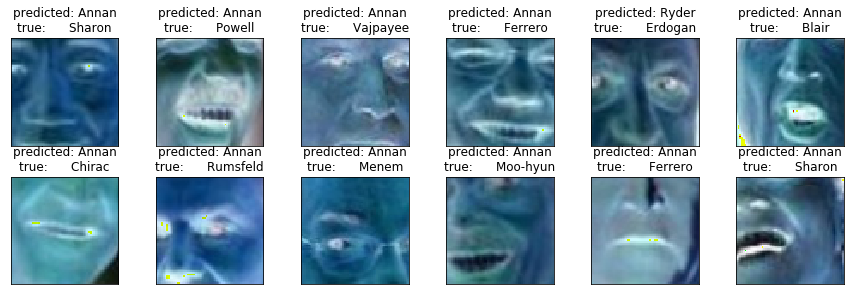

In [25]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(predicted, actual, labels_names_selected, i)
                         for i in range(predicted.shape[0])]

n_row=2
n_col=6

pl.figure(figsize=(2 * n_col, 1.9 * n_row))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.29)
for i in range(n_row * n_col):
    pl.subplot(n_row, n_col, i + 1)
    pl.imshow(X_test[i].reshape((63, 63,3)))
    pl.title(prediction_titles[i], size=12)
    pl.xticks(())
    pl.yticks(())

As you can see, the model is currently not predicting well, and that is evident before testing via tensorboard.  The images below in training overview for the augmented data model show that the model has not had enough time to learn from the features.  With more training time, I believe this model will perform better.  The model may also perform better if the crop size is increased.  The current size, does not capture the whole face and would make it more dificult for hte model to predict who is portrayed.

## Training Overview

### Augmented Data Model Training

Accuracy

![aug_acc](imgs/augmented_model_training_acc.png)
![aug_loss](imgs/augmented_model_training_loss.png)

This is the best performing model being trained on the augmented data.

Due to the few training epochs, it is not possible to derive a conclusion on how well the model is performing.

### Best Performing Model

![best_acc](imgs/best_full_model_training_acc.png)
![best_loss](imgs/best_full_model_training_loss.png)

This is my best training.

The blue line is the validation, and the orange line is the training.  The ending accuracies are 0.7 and 0.8 for validation and training respectively.  Looking at the loss, we can see that after 1000 epochs, the validation loss is rising, leading me to belive that the model was overfitting. After testing the model, it was evedent that the model was severly overfitted, having such a high difference between accuracies and increasing validation loss.

### Worst Performing Model

![worst_acc](imgs/underfit_full_model_training_acc.png)
![worst_loss](imgs/underfit_full_model_training_loss.png)

This is my worst training.

The green line is the validation, and the pink line is the training.  With the validation accuracy being higher than the training accuracy and the valdiation loss being lower than the training loss, it is clear the the model is underfitting.  After testing the model, it was clear the the model was unable to learn from the features.